In [1]:
import numpy as np

def generate_walsh_matrix(n):
    if n == 1:
        return np.array([[1, 1], [1, -1]])
    smaller = generate_walsh_matrix(n - 1)
    top = np.hstack((smaller, smaller))
    bottom = np.hstack((smaller, -smaller))
    return np.vstack((top, bottom))

def cdma_simulation(num_users=8, intended_bit=1, noise_floor=1e-6):
    walsh_matrix = generate_walsh_matrix(int(np.log2(num_users)))
    print("Walsh Code Matrix:")
    print(walsh_matrix)
    print("\n" + "="*50 + "\n")

    intended_index = np.random.randint(0, num_users)
    print(f"Intended User: {intended_index+1}, Transmitting bit: {intended_bit}\n")

    transmitted_signal = intended_bit * walsh_matrix[intended_index].astype(np.float64)
    noise = np.random.normal(0, np.sqrt(noise_floor), num_users)
    noisy_signal = transmitted_signal + noise

    print("Transmitted Signal (before noise):")
    print(transmitted_signal)
    print("\nNoise Added:")
    print(noise)
    print("\nReceived Signal (with noise):")
    print(noisy_signal)
    print("\n" + "="*50 + "\n")

    results = []
    for i in range(num_users):
        correlation = np.dot(noisy_signal, walsh_matrix[i]) / num_users
        signal_power = correlation**2

        if i == intended_index:
            noise_power = np.var(noise)
        else:
            interference = np.dot(walsh_matrix[intended_index], walsh_matrix[i]) / num_users
            noise_power = interference**2 + np.var(noise)
        if noise_power > 0:
            snr = signal_power / noise_power
            if snr > 0:
                snr_db = 10 * np.log10(snr)
            else:
                snr_db = float('-inf')
        else:
            snr = float('inf')
            snr_db = float('inf')
        results.append({
            'user': i + 1,
            'type': 'Intended' if i == intended_index else 'Unintended',
            'correlation': correlation,
            'signal_power': signal_power,
            'noise_power': noise_power,
            'snr_db': snr_db
        })

    print("User\tType\tCorrelation\tSignal Power\tNoise Power\tSNR (dB)")
    print("-"*80)

    for res in results:
        print(f"{res['user']}\t{res['type']:12}\t{res['correlation']:+.4f}\t"
              f"{res['signal_power']:.6f}\t{res['noise_power']:.6f}\t"
              f"{res['snr_db']:+.2f}")

    intended = results[intended_index]
    unintended = [r for r in results if r['type'] == 'Unintended']
    avg_unintended_snr = np.mean([r['snr_db'] for r in unintended])

    print("\nSUMMARY RESULTS:")

    print(f"Intended User {intended['user']}: ")
    print(f"Correlation: {intended['correlation']:+.4f}")
    print(f"SNR: {intended['snr_db']:+.2f} dB")
    print(f"Signal Power: {intended['signal_power']:.6f}")
    print(f"Noise Power: {intended['noise_power']:.6f}")

    print("\nAverage Unintended User:")
    print(f"Avg Correlation: {np.mean([r['correlation'] for r in unintended]):+.6f}")
    print(f"Avg SNR: {avg_unintended_snr:+.2f} dB")
    print(f"Avg Signal Power: {np.mean([r['signal_power'] for r in unintended]):.6f}")
    print(f"Avg Noise Power: {np.mean([r['noise_power'] for r in unintended]):.6f}")

if __name__ == '__main__':
    cdma_simulation(num_users=8, intended_bit=1, noise_floor=1e-6)

Walsh Code Matrix:
[[ 1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [ 1  1 -1 -1  1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1  1]
 [ 1  1  1  1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1 -1 -1  1  1]
 [ 1 -1 -1  1 -1  1  1 -1]]


Intended User: 5, Transmitting bit: 1

Transmitted Signal (before noise):
[ 1.  1.  1.  1. -1. -1. -1. -1.]

Noise Added:
[-8.35130650e-04  9.15054293e-04  1.89146445e-03 -1.37739855e-04
 -1.88988967e-03 -5.87933065e-04 -5.69211709e-05 -1.26774997e-03]

Received Signal (with noise):
[ 0.99916487  1.00091505  1.00189146  0.99986226 -1.00188989 -1.00058793
 -1.00005692 -1.00126775]


User	Type	Correlation	Signal Power	Noise Power	SNR (dB)
--------------------------------------------------------------------------------
1	Unintended  	-0.0002	0.000000	0.000001	-13.22
2	Unintended  	+0.0000	0.000000	0.000001	-33.63
3	Unintended  	-0.0004	0.000000	0.000001	-10.08
4	Unintended  	-0.0008	0.000001	0.000001	-3.13
5	Intended    	+1.0007	1.001410	0.000001	+58.96
6

[ True False False  True False False  True  True False  True]
[ 1 -1 -1 ... -1  1  1]


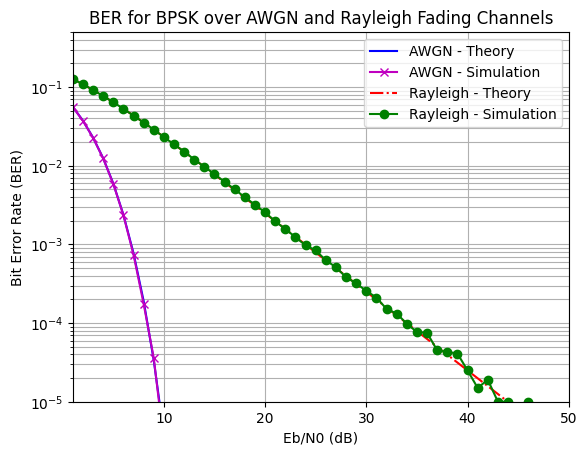

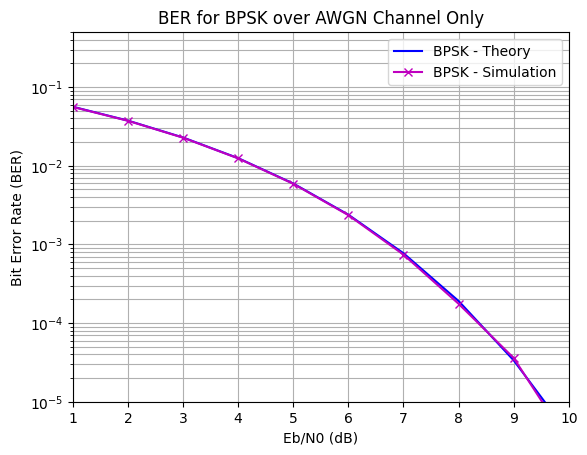

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Simulation Parameters
num_bits = 10**6  # Number of bits to transmit
np.random.seed(100)  # Seed for reproducibility

# Generate random bits (0 or 1)
bits = np.random.rand(num_bits) > 0.5
print(bits[:10])

# BPSK Modulation: 0 -> -1, 1 -> +1
bpsk_symbols = 2 * bits - 1
print(bpsk_symbols)

# AWGN Noise (complex Gaussian noise)
noise = (1 / np.sqrt(2)) * (np.random.randn(num_bits) + 1j * np.random.randn(num_bits))

# Eb/N0 values in dB
eb_n0_dB_range = np.arange(0, 61)

# Initialize Error Counters
errors_total = np.zeros(len(eb_n0_dB_range))
errors_awgn = np.zeros(len(eb_n0_dB_range))
errors_rayleigh = np.zeros(len(eb_n0_dB_range))

# Simulation Loop over Eb/N0 values
for idx, eb_n0_dB in enumerate(eb_n0_dB_range):

    # Noise scaling for given Eb/N0
    scaled_noise = 10 ** (-eb_n0_dB / 20) * noise

    # --- AWGN Channel ---
    received_awgn = bpsk_symbols + scaled_noise
    detected_bits_awgn = (np.real(received_awgn) > 0)
    errors_awgn[idx] = np.sum(bits != detected_bits_awgn)

    # --- Rayleigh Fading Channel ---
    rayleigh_channel = (1 / np.sqrt(2)) * (np.random.randn(num_bits) + 1j * np.random.randn(num_bits))
    received_rayleigh = rayleigh_channel * bpsk_symbols + scaled_noise
    equalized_rayleigh = received_rayleigh / rayleigh_channel
    detected_bits_rayleigh = (np.real(equalized_rayleigh) > 0)
    errors_rayleigh[idx] = np.sum(bits != detected_bits_rayleigh)

    # --- Overall Error (AWGN) - Duplicate of AWGN here for comparison
    received_signal = bpsk_symbols + scaled_noise
    detected_bits = (np.real(received_signal) > 0)
    errors_total[idx] = np.sum(bits != detected_bits)

# Compute BER
ber_simulated = errors_total / num_bits
ber_simulated_awgn = errors_awgn / num_bits
ber_simulated_rayleigh = errors_rayleigh / num_bits

# Theoretical BER
ber_theoretical_awgn = 0.5 * erfc(np.sqrt(10 ** (eb_n0_dB_range / 10)))
ber_theoretical_rayleigh = 0.5 * (1 - np.sqrt(10 ** (eb_n0_dB_range / 10) / (1 + 10 ** (eb_n0_dB_range / 10))))

# ---------------------- Plotting ---------------------- #

# Plot 1: AWGN and Rayleigh
plt.figure()
plt.semilogy(eb_n0_dB_range, ber_theoretical_awgn, 'b-', label='AWGN - Theory')
plt.semilogy(eb_n0_dB_range, ber_simulated_awgn, 'mx-', label='AWGN - Simulation')
plt.semilogy(eb_n0_dB_range, ber_theoretical_rayleigh, 'r-.', label='Rayleigh - Theory')
plt.semilogy(eb_n0_dB_range, ber_simulated_rayleigh, 'go-', label='Rayleigh - Simulation')
plt.axis([1, 50, 1e-5, 0.5])
plt.grid(True, which='both')
plt.legend()
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER for BPSK over AWGN and Rayleigh Fading Channels')
plt.savefig('bpsk_awgn_rayleigh.png')

# Plot 2: Only AWGN
plt.figure()
plt.semilogy(eb_n0_dB_range, ber_theoretical_awgn, 'b-', label='BPSK - Theory')
plt.semilogy(eb_n0_dB_range, ber_simulated, 'mx-', label='BPSK - Simulation')
plt.grid(True, which='both')
plt.axis([1, 10, 1e-5, 0.5])
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER for BPSK over AWGN Channel Only')
plt.legend()
plt.savefig('bpsk_awgn_only.png')


In [ ]:
# CLIENT.PY
import socket

def send_file(host="localhost", port=12345, file_path=""):
    client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_socket.connect((host, port))
    print(f"Client Connected to {host}:{port}")

    with open(file_path, "rb") as file:
        while True:
            data = file.read(1024)
            if not data:
                break
            client_socket.send(data)

    print("Data Send Successfully")

if __name__ == "__main__":
    send_file(
        host="localhost",
        port=12345,
        file_path="datafile.txt"
    )

# SERVER.PY
import socket

def start_server(host="localhost", port=12345):
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((host, port))
    server_socket.listen(1)

    client_server, client_address = server_socket.accept()
    print(f"Server Connection Established with {client_address}")

    received_data = b""
    with open("received_data.txt", "wb") as file:
        while True:
            data = client_server.recv(1024)
            if not data:
                break
            received_data += data
            file.write(data)

    print(received_data.decode())
    client_server.close()
    server_socket.close()

if __name__ == "__main__":
    start_server(
        host="localhost",
        port=12345
    )

In [ ]:
# Router>enable
# Router#config terminal
# Router(config)#int fa0/0
# Router(config-if)#ip add 192.168.1.1 255.255.255.0
# Router(config-if)#no shutdown
# Router(config-if)#exit

# Router(config)#
# Router(config)#ip dhcp pool MY_LAN
# Router(dhcp-config)#network 192.168.1.0 255.255.255.0
# Router(dhcp-config)#default-router 192.168.1.1
# Router(dhcp-config)#dns-server 192.168.1.10

# Router(config)#ip dhcp excluded-address 192.168.1.1 192.168.1.10